In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from LPSolver import LPSolver
from QPSolver import QPSolver
from SOCPSolver import SOCPSolver
from LassoSolver import LassoSolver
import cvxpy as cp

In [60]:
rng = np.random.default_rng(10)

### Generate a feasible problem instance

In [61]:
m = 80  # number of equality constraints -- keep lower than number of variables to ensure there are multiple solutions to the problem
n = 100  # number of variables

A = rng.normal(size = (m,n))

random_row_index = np.random.choice(m)

# Set all entries in the selected row to their absolute values
A[random_row_index, :] = np.abs(A[random_row_index, :])

b = A@np.abs(rng.normal(size = (n,)))
c = rng.normal(size = (n,))

### Create a LPSolver object

Can specify use_gpu = True if you want to run with a GPU. GPU solver typically starts to surpass performance of CPU solver ~500 variables (depending on system)

Also able to make multiple instances of this object to compare different hyperparameters

In [89]:
""""Initialize LP problem of form:
        Minimize c^T x
        Subject to Ax == b
                   Cx <= d
                   lower_bound <= x <= upper_bound

Can leave A, b, C, d, and c as None or specify matrices/vectors to constrain the problem
"""

ls= LPSolver(c=c,
        A=A,
        b=b,
        C=None,
        d=None,
        use_gpu=False,
        upper_bound=3,
        lower_bound=0,
        update_slacks_every=5,
        suppress_print=False)


Not able to run with GPU
Testing CVXPY


#### Compare LPSolver solution to the CVXPY solution
Check the ls.value parameter if you want to extract the value of the solution, use ls.xstar to get the minimizer

In [90]:
ls.solve(track_loss=True) - ls.cvxpy_val

proceeding to solve method
Objective value is now -7.821270181214127
Objective value is now -9.056109597164873
Objective value is now -13.795599994280783
Objective value is now -14.648400867663327
Objective value is now -14.705223388749173
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -14.708923873448619
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -14.70916981482835
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -14.709185929948589
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -14.709209564370934
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -14.709133349083984
Reached max Newton steps during 10th centering step (t=3844335937.5)
Backtracking search got stuck, returning from Newton's method now...
Newton step at iteration 11 did not converge
Back

-2.2267986357960012e-05

<Axes: title={'center': 'Convergence of LPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

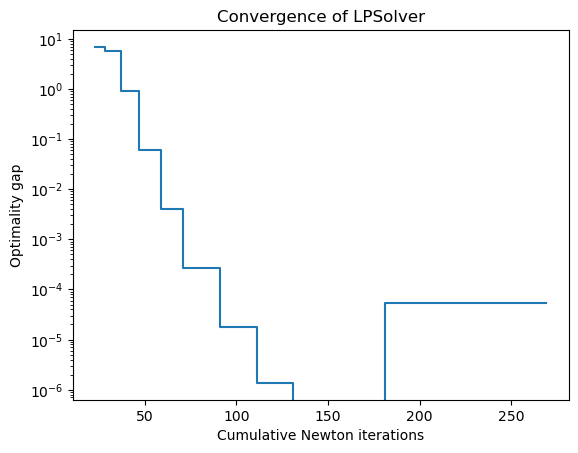

In [91]:
ls.plot() # the algorithm quit once the objective value stopped decreasing (which may happen in equality constrained problems)

### Benchmark LPSolver times vs. CVXPY
Can also generate multiple instances of LP to benchmark times of different hyperparameters

In [ ]:
%%timeit
x = cp.Variable(len(c))
obj = cp.Minimize(c.T@x)
constr = [A@x == b,
        x <= 0]
prob = cp.Problem(obj, constr)
prob.solve(solver='CLARABEL')


4.71 s ± 40.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit ls.solve(resolve=True)

2.03 s ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit ls_gpu.solve(resolve=True)

250 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<Axes: title={'center': 'Convergence of LPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

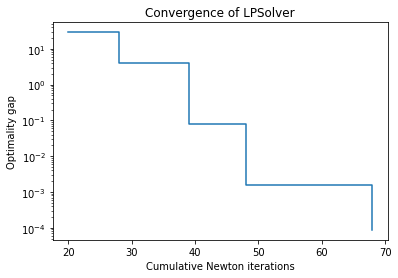

In [ ]:
ls_gpu.plot()

### Try out an inequality constrained problem (solver will run phase 1)

In [93]:
n = 100
m = 50
C = np.random.random((m,n))
C = np.where(np.random.binomial(1, 0.10, C.shape), C, 0)  # <- apply a random mask with 10% density  (A will be 90% sparse)
d = np.random.randint(low=1, high=30, size=C.shape[0])

c = np.random.randint(low=1, high=n, size=C.shape[1]) - n/2

Not able to run with GPU
Not able to run with GPU


In [112]:
# provide an x0 to force the solver to complete phase 1 solve

ls= LPSolver(c=c,
        A=A,
        b=b,
        C=C,
        d=d,
        use_gpu=False,
        upper_bound=None,
        lower_bound=0,
        suppress_print=False,
        epsilon=1e-10,
        t0=1,
        update_slacks_every=5,
        x0=np.ones(len(c)))

Testing CVXPY
Starting slack of 5.9864


In [113]:
ls.solve() - ls.cvxpy_val

running phase 1 solver
Current slack: 5.98635554133264
Current slack: 14996.304442001596
Current slack: 997.1863898023126
Current slack: 64.07406255477198
Current slack: 2.6033319649533615
found a feasible point with slack -0.22639232027039274
proceeding to solve method
Objective value is now -8541.665643336326
Objective value is now -8632.511509201697
Objective value is now -8638.664775554995
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -8639.075412302309
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -8639.102790126659
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -8639.104614067735
Cholesky solver failed due to numeric instability. Proceeding with Numpy solve...
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -8639.104803633845
Backtracking search got stuck, returning from Newton's method now...
Objectiv

-5.82852226216346e-05

### Run the same problem, but turn it into a QP by passing the identity matrix to P in QPSolver

In [109]:
# Also add in a dummy equality constraint just to showcase capability
# for example, here we are forcing the first entry in x to be 1
A = np.hstack((1, np.zeros(len(c)-1))).reshape(1,-1)
b = np.array([1])

qs= QPSolver(P=np.eye(len(c)), 
        q=c,
        A=A,
        b=b,
        C=C,
        d=d,
        t0=0.1,
        use_gpu=False,
        upper_bound=None,
        lower_bound=0,
        suppress_print=False,
        mu=15,
        x0 = np.ones(len(c))*10,
        update_slacks_every=0)

Testing CVXPY
Starting slack of 78.7609


In [110]:
qs.solve(track_loss=True) - qs.cvxpy_val

running phase 1 solver
Current slack: 78.76085151472293
Current slack: 14996.928601058991
Current slack: 997.1866137531274
Current slack: 64.07406263767669
Current slack: 2.6033319649561926
found a feasible point with slack -0.22639232027036854
proceeding to solve method
Objective value is now -4620.589435840365
Objective value is now -5316.442786746958
Objective value is now -5370.8392221072345
Objective value is now -5374.525486524601
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -5374.746225631481
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -5374.788549248652
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -5374.789538351915
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -5374.789722506872
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -5374.789725911084
Back

-1.0571115126367658e-05

<Axes: title={'center': 'Convergence of QPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

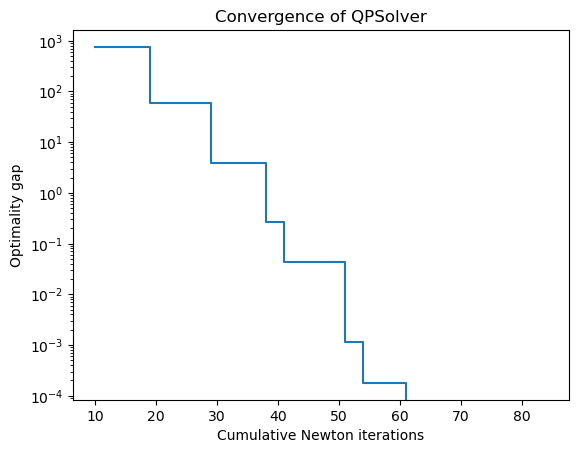

In [111]:
qs.plot()

## SOCP Solver

In [114]:
# Load in data from HW5

LAMBDA = 0.02
RHO = 0.4
T = 10
GROUPS = [
    [0],
    [1],
    [2],
    [3, 4, 5, 6, 7],
    [8, 9, 10, 11, 12, 13],
    [14, 15],
    [16],
    [17],
    [18],
]
FSTAR = 49.9649387126726

def get_weights(groups):

    group_sizes = list(map(len, groups))
    weights = np.sqrt(group_sizes)
    return weights

def load_data(X_train_path, y_train_path):
    X_train = np.loadtxt(X_train_path, delimiter=",")
    X_train = np.hstack([np.ones(X_train.shape[0])[:, np.newaxis], X_train])
    y_train = np.loadtxt(y_train_path, delimiter=",")
    return X_train, y_train

X, Y = load_data('example_data/X_train.csv', 'example_data/Y_train.csv')
w = get_weights(GROUPS)[1:]

In [115]:
# transform into format for SOCPSolver

P = np.zeros((27,27))
P[:19,:19] = 1/(X.shape[0]) * X.T@X
q = np.zeros(27)
q[:19] = -1/(X.shape[0]) * Y.T@X
q[19:] = LAMBDA * w
A = []
c = []
for i in range(len(GROUPS)-1):
    Ai = np.zeros((27,27))
    ci = np.zeros(27)
    Ai[GROUPS[i+1], GROUPS[i+1]] = 1
    A.append(Ai)
    ci[i+19] = 1
    c.append(ci)

In [119]:
scs = SOCPSolver(P=P, 
        q=q,
        A=A,
        b=None,
        c=c,
        d=None,
        use_gpu=False,
        upper_bound=None,
        lower_bound=None,
        suppress_print=False)

Testing CVXPY
Starting slack of 2.969


### Currently running into occasional bug where phase 1 solver converges to small positive number!

In [120]:
scs.solve() - scs.cvxpy_val

running phase 1 solver
Current slack: 2.968956478616826
Cholesky solver failed due to numeric instability. Proceeding with Numpy solve...
found a feasible point with slack -242.59279408119625
proceeding to solve method
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -270.9968954680217
Reached max Newton steps during 1th centering step (t=0.1)
Objective value is now -418.3762764785082
Objective value is now -427.189927748653
Objective value is now -427.6315154356971
Objective value is now -427.65697057132735
Objective value is now -427.6586333162318
Objective value is now -427.6587440266498
Objective value is now -427.65875141953455
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -427.6587518477065
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -427.65875184974743
Backtracking search got stuck, returning from Newton's method now...
Objective 

3.5586822377808858e-09

In [121]:
# confirm that we get the same solution as in the homework

scs.value + Y.T@Y/(2*X.shape[0]), FSTAR

(49.96493879693293, 49.9649387126726)

### Random problem generation

In [125]:
m = 10
n = 50
p = 10
n_i = 15
f = np.random.randn(n)
A = []
b = []
c = []
d = []
x0 = np.random.randn(n)
for i in range(m):
    A.append(np.random.randn(n_i, n))
    b.append(np.random.randn(n_i))
    c.append(np.random.randn(n))
    d.append(np.linalg.norm(A[i] @ x0 + b[i], 2) - c[i].T @ x0)
F = np.random.randn(p, n)
g = F @ x0

In [134]:
scs = SOCPSolver(P=None, 
        q=f,
        A=A,
        b=b,
        c=c,
        d=d,
        F=None,
        g=None,
        use_gpu=False,
        upper_bound=None,
        lower_bound=None,
        suppress_print=False,
        update_slacks_every=0,
        check_cvxpy=True,
        alpha=0.02,
        x0=np.ones(len(f))*1)

#scs.solve(track_loss=True) - scs.cvxpy_val

Testing CVXPY
Starting slack of 861.9187


In [135]:
scs.solve(track_loss=True) - scs.cvxpy_val

running phase 1 solver
Current slack: 861.9187066433233
found a feasible point with slack -81.72190907530921
proceeding to solve method
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -64.587393885886
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -112.57500020632511
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -117.48027444243709
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -118.36416778880648
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -118.38082392636395
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -118.40665911644221
Backtracking search got stuck, returning from Newton's method now...
Objective value is now -118.41737793287118
Backtracking search got stuck, returning from Newton's method now...
Objective valu

1.6654780552016746e-05

<Axes: title={'center': 'Convergence of SOCPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

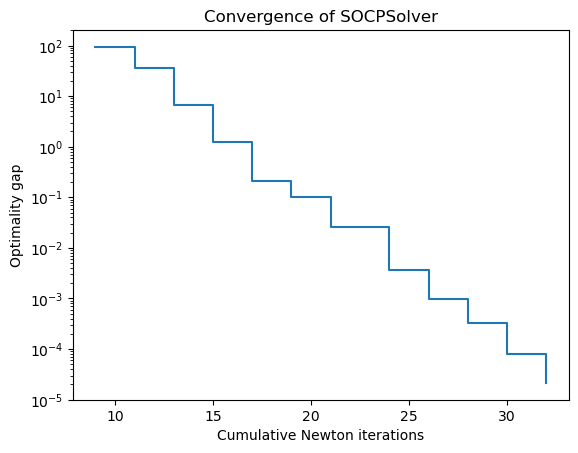

In [15]:
scs.plot()

### Benchmark SOCP Solver

In [136]:
scs = SOCPSolver(P=None, 
        q=f,
        A=A,
        b=b,
        c=c,
        d=d,
        F=F,
        g=g,
        use_gpu=False,
        upper_bound=None,
        lower_bound=None,
        suppress_print=True,
        update_slacks_every=0,
        check_cvxpy=False)

#scs.solve(track_loss=True) - scs.cvxpy_val

In [19]:
%%timeit 
# Define and solve the CVXPY problem.
x = cp.Variable(n)
# We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
soc_constraints = [
      cp.SOC(c[i].T @ x + d[i], A[i] @ x + b[i]) for i in range(m)
]
prob = cp.Problem(cp.Minimize(f.T@x),
                  soc_constraints + [F @ x == g])
prob.solve()

/Users/frankdeguire/anaconda3/envs/ee364/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


19.4 s ± 3.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit scs.solve(track_loss=False)

2.89 s ± 355 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
prob.value, scs.value

(-1298.4653910738707, -1298.4653972079934)

<Axes: title={'center': 'Convergence of SOCPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

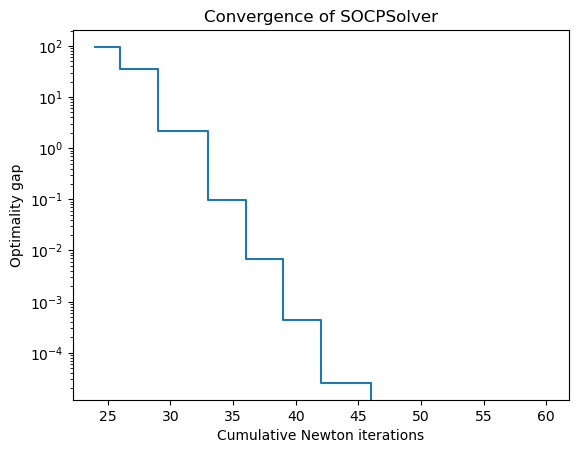

In [30]:
scs.plot()

## LassoSolver

(Our true winnner)

### Generate random problem data

Generate a sparse x so that it replicates a LASSO problem well. Generate multiple problem instances by generating a B matrix instead of just a vector

In [23]:
m = 500
n = 150
num_problems = 30
num_nonzero = 1000 # create a sparse x_true with this many nonzero entries
A = np.random.rand(m, n)
x_true = np.zeros((n, num_problems))
x_true[np.unravel_index(np.random.randint(0,n*num_problems, num_nonzero), (n, num_problems))] = np.random.uniform(0,50, num_nonzero)
reg = 0.05 + 0.01*np.random.randn(num_problems) # give each subproblem a slightly different regularization
B = A@x_true + np.random.randn(m, num_problems)

In [24]:
# create the LassoSolver object to solve all subproblems in parallel
# add the bias term and normalize A and then compare to CVXPY solver

ls = LassoSolver(
        A,
        B,
        reg=reg,
        rho=0.4,
        max_iters=1000,
        check_stop=10,
        add_bias=True,
        normalize_A=True,
        positive=False,
        compute_loss=True,
        adaptive_rho=False,
        eps_abs=1e-6,
        eps_rel=1e-4,
        use_gpu=False,
        num_chunks=0
    )


Testing CVXPY
CVXPY solving sample 1...Optimal value of 8.5134
CVXPY solving sample 2...Optimal value of 15.3696
CVXPY solving sample 3...Optimal value of 6.7719
CVXPY solving sample 4...Optimal value of 13.7393
CVXPY solving sample 5...Optimal value of 14.8268
CVXPY solving sample 6...Optimal value of 11.2279
CVXPY solving sample 7...Optimal value of 13.0617
CVXPY solving sample 8...Optimal value of 7.5663
CVXPY solving sample 9...Optimal value of 8.452
CVXPY solving sample 10...Optimal value of 11.3587
CVXPY solving sample 11...Optimal value of 9.579
CVXPY solving sample 12...Optimal value of 14.5551
CVXPY solving sample 13...Optimal value of 16.4474
CVXPY solving sample 14...Optimal value of 18.2706
CVXPY solving sample 15...Optimal value of 12.8363
CVXPY solving sample 16...Optimal value of 9.7036
CVXPY solving sample 17...Optimal value of 12.2318
CVXPY solving sample 18...Optimal value of 15.5859
CVXPY solving sample 19...Optimal value of 11.9294
CVXPY solving sample 20...Optimal 

In [25]:
X, solutions, gaps, iters = ls.solve()

In [26]:
# LassoSolver actually achieved lower objective values than CVXPY!
solutions - ls.cvxpy_vals

array([-0.02998526, -0.02605976, -0.00041404, -0.0524055 , -0.05616224,
       -0.01734689, -0.04153745, -0.00364761, -0.03187835, -0.02356449,
       -0.01958842, -0.03259362, -0.04862576, -0.05271794, -0.06422837,
       -0.01690379, -0.0262829 , -0.06294509, -0.01991161, -0.02811559,
       -0.02073896, -0.02931188, -0.01732493, -0.02096987, -0.02420308,
       -0.03021745, -0.06417266, -0.00821221, -0.00873121, -0.00733874])

<Axes: title={'center': 'Convergence of LassoSolver'}, xlabel='iteration number', ylabel='Optimality gap'>

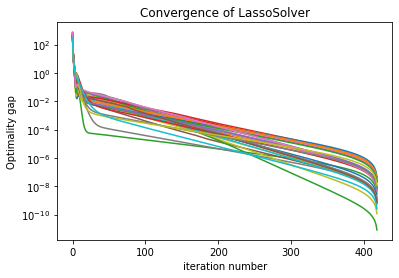

In [27]:
# note that, because LassoSolver achieved better objective values than CVXPY, the optimal value was considered the value at the end of the LassoSolver solve, which is why
# the optimality gap goes to negative infinity on the log plot
ls.plot()

### Benchmark against CVXPY
#### One good use case of solving multiple problems in parallel is being able to test several regularization strengths at the same time

In [28]:
# generate data
# have one vector for b (only solving one problem instance), but generate multiple values for regularization strength
# test 50 different regularization strengths logarithmically spaced from 10^-5 to 10^2

m = 800
n = 400
num_problems = 1
num_nonzero = 10000 # create a sparse x_true with this many nonzero entries
A = np.random.rand(m, n)
x_true = np.zeros((n, num_problems))
x_true[np.unravel_index(np.random.randint(0,n*num_problems, num_nonzero), (n, num_problems))] = np.random.uniform(0,50, num_nonzero)
reg = np.logspace(-5,2,50)
b = A@x_true + np.random.randn(m, num_problems)


In [73]:
# create the LassoSolver object to solve all subproblems in parallel
# turn off compute loss and lower epsilons a bit (resort to defauly -- we were already outperforming CVXPY anyways)
# add a bias term, but don't normalize A here

ls = LassoSolver(
        A,
        b,
        reg=reg,
        rho=0.004,
        max_iters=10000,
        check_stop=100,
        add_bias=True,
        normalize_A=False,
        positive=False,
        compute_loss=False,
        adaptive_rho=False,
        use_gpu=True,
        num_chunks=0,
        eps_rel=1e-6,
    eps_abs=1e-6,
        check_cvxpy=False
    )

In [30]:
# time how long it takes to solve all the problems in CVXPY (we must solve sequentially)
from time import time
vals = []
A = np.hstack((np.ones((m,1)), A))
start = time()
for r in reg:
    x = cp.Variable(n+1)
    obj = cp.Minimize(1/(2*m)*cp.norm2(A@x - b[:,0])**2 + r*cp.norm(x[1:], 1))
    prob = cp.Problem(obj, [])
    prob.solve(solver='CLARABEL')
    vals.append(prob.value)
print(time()-start)

57.54086780548096


In [38]:
ls.solutions.get() - np.array(vals)

array([ 2.03676304e-06,  2.48952755e-06,  2.80171960e-06,  2.62359206e-06,
        1.19473962e-06,  1.06894333e-07,  2.05324122e-08,  4.18690793e-09,
        3.55764307e-10,  1.03648645e-10,  8.30225666e-10,  1.57042823e-09,
        1.56147628e-09,  6.85477453e-10,  6.00230976e-12,  2.91725577e-09,
        1.84500983e-08,  6.69775062e-08,  1.93903119e-07,  4.62686238e-07,
        1.04002318e-06,  1.91174580e-06,  2.38510839e-06,  4.03184561e-06,
        6.83488480e-06,  1.82919687e-05,  2.09881954e-05,  2.08803473e-05,
        2.21523495e-05,  1.40516140e-05,  6.44777606e-06,  4.90681168e-06,
       -1.22348183e-06, -7.85770681e-07, -1.44148689e-05, -1.05966301e-05,
       -1.89473831e-05, -3.69965710e-06, -1.12832367e-05, -3.56014370e-05,
       -1.35434857e-06, -4.75865454e-06, -3.23347558e-06, -2.36963388e-07,
       -2.48328433e-08, -5.80257620e-08, -1.70943167e-07, -3.57315002e-07,
       -6.49673893e-07, -1.09386929e-06])

In [100]:
%timeit ls.solve() # not bad for solving 50 different LASSO problems simultaneously -- and without GPU!
# we will get even better relative performance as problem size increases and GPU is implemented

1.08 s ± 260 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
# and just another sanity check: LassoSolver once again matches with CVXPY
ls.solve()
np.linalg.norm(ls.X[:,-1] - x.value)

0.004407873999298317

In [74]:
from time import time
tic = time()
ls.solve()
toc = time()
print(toc-tic)

0.18696284294128418


In [75]:
ls.solutions

array([3.77291905e-01, 4.16801762e-01, 4.71700250e-01, 5.47980911e-01,
       6.53971500e-01, 8.01242930e-01, 1.00587202e+00, 1.29019571e+00,
       1.68524767e+00, 2.23414256e+00, 2.99677543e+00, 4.05634588e+00,
       5.52841255e+00, 7.57345311e+00, 1.04142759e+01, 1.43601346e+01,
       1.98400848e+01, 2.74490397e+01, 3.80112007e+01, 5.26671374e+01,
       7.29927976e+01, 1.01160649e+02, 1.40158808e+02, 1.94086374e+02,
       2.68523963e+02, 3.71008303e+02, 5.11632570e+02, 7.03754831e+02,
       9.64684947e+02, 1.31638713e+03, 1.78561417e+03, 2.40261896e+03,
       3.19803411e+03, 4.19999079e+03, 5.41723236e+03, 6.83762669e+03,
       8.40369929e+03, 9.98345685e+03, 1.14164258e+04, 1.24909583e+04,
       1.30425732e+04, 1.31596845e+04, 1.31655210e+04, 1.31655210e+04,
       1.31655210e+04, 1.31655210e+04, 1.31655210e+04, 1.31655210e+04,
       1.31655210e+04, 1.31655210e+04])

In [76]:
ls.num_iterations

[600]

In [77]:
vals - ls.solutions.get()

array([ 5.15071319e-12,  5.00088859e-12,  3.91908728e-13,  2.26664243e-11,
        2.70840017e-11,  1.99382733e-11,  1.22346577e-13,  4.10560475e-12,
        2.50843790e-11,  6.70574707e-14,  4.28226343e-11,  3.48165941e-13,
       -8.88178420e-16,  3.17132987e-11,  3.26849658e-13,  3.95772304e-12,
        5.05551156e-11,  4.92768493e-10,  6.61017907e-10,  5.54152280e-10,
        5.67564484e-09,  9.83858683e-09,  1.11589316e-08,  1.17243530e-08,
        4.67383984e-07,  2.22563244e-07,  9.64381002e-08,  2.27995088e-07,
        2.12738087e-07,  2.22895096e-07,  1.61475600e-06,  1.37308598e-06,
        2.29492844e-06,  1.02773993e-06,  1.44165124e-05,  1.05966228e-05,
        1.89474013e-05,  3.69963163e-06,  1.12829639e-05,  3.54047952e-05,
       -2.31481499e-06, -8.07198739e-06, -9.52437586e-06, -1.25208862e-05,
       -1.27330186e-05, -1.26998239e-05, -1.25869065e-05, -1.24005328e-05,
       -1.21081757e-05, -1.16639821e-05])